author: Vinayak Kumar
inspired by: https://github.com/dkohlsdorf/Variational-Fashion-Encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

from scipy.misc import imsave
from scipy.misc import imresize

C:\Users\40750\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
labels_dict = {
    0: "T-shirt-top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [3]:
data = input_data.read_data_sets('data/fashion/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


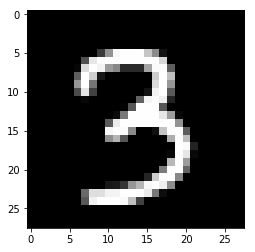

In [21]:
img = data.train.images[1]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [4]:
n_samples = data.train.num_examples
np.random.seed(0)
tf.set_random_seed(0)

In [5]:
def xavier(nin, nout):
    hi = np.sqrt( 6 / (nin + nout))
    lo = -hi
    w  = tf.random_uniform((nin, nout), minval=lo, maxval=hi, dtype= tf.float32)
    return w

def bias(nout):
    return tf.zeros([nout], dtype=tf.float32)

def layer(x, l, nin, nout):
    w = tf.Variable(xavier(nin, nout), name="W" + str(l))    
    b = tf.Variable(bias(nout), name= "b" + str(l))
    z = tf.matmul(x, w) + b
    return z

In [6]:
def encoder(x, shapes):         
    a = x
    l = 0
    for nin, nout in shapes:
        if l == len(shapes) - 1:
            z = layer(a, l, nin, nout * 2) # In the last layer, the embedding represents the mean and variance concat
            a = tf.nn.tanh(z)
        else:            
            z = layer(a,l, nin, nout)
            a = tf.nn.relu(z)
        l += 1
    n_out = int(int(a.shape[1]) / 2)       
    mean = a[:, n_out:]
    sigm = 1e-6 + tf.nn.softplus(a[:, :n_out])
    return (mean, sigm)

In [7]:
def decoder(x, shapes):         
    a = x
    l = 0
    for nin, nout in shapes:     
        z = layer(a, l, nin, nout)
        if l == 0:
            a = tf.nn.tanh(z)
        elif l == len(shapes) - 1:
            a = tf.nn.sigmoid(z)
        else:            
            a = tf.nn.relu(z)
        l += 1
    return a

In [8]:
def vae(x, enc_shapes, dec_shapes):
    mu, sigm = encoder(x, enc_shapes)
    sample = mu + sigm * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
    y = decoder(sample, dec_shapes)
    
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigm) - tf.log(1e-8 + tf.square(sigm)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO
    return y, sample, loss, -marginal_likelihood, KL_divergence

In [9]:
def reverse(shapes):
    x = [(o, i) for i, o in shapes]
    x.reverse()
    return x

input_layer = tf.placeholder(tf.float32, shape=(None, 784))
enc_shapes = [
    (784, 512),
    (512, 256),
    (256, 128)
]
dec_shapes = reverse(enc_shapes)

rate = 0.001
batch_size = 100
total_batch = int(n_samples / batch_size)
epochs = 1

y, z, loss, neg_marginal_likelihood, KL_divergence = vae(input_layer, enc_shapes, dec_shapes)
train_op = tf.train.AdamOptimizer(rate).minimize(loss)

Learning: 
   - epoch:  0 94655.67832946777 86628.23516845703 8027.443215847015
Reconstruction: 
 - reconstructing: Ankle boot 0 0 0
 - reconstructing: Trouser 0 0 1
 - reconstructing: Sandal 0 0 2
 - reconstructing: T-shirt-top 0 0 3
 - reconstructing: Pullover 0 0 4
 - reconstructing: Pullover 0 0 5
 - reconstructing: Bag 0 0 6
 - reconstructing: Sneaker 0 0 7
 - reconstructing: T-shirt-top 0 0 8
 - reconstructing: Pullover 0 0 9
 - reconstructing: Sneaker 0 0 10
 - reconstructing: Trouser 0 0 11
 - reconstructing: Pullover 0 0 12
 - reconstructing: Sandal 0 0 13
 - reconstructing: Trouser 0 0 14
 - reconstructing: Dress 0 0 15
 - reconstructing: Dress 0 0 16
 - reconstructing: Ankle boot 0 0 17
 - reconstructing: T-shirt-top 0 0 18
 - reconstructing: Bag 0 0 19
 - reconstructing: Shirt 0 0 20
 - reconstructing: Shirt 0 0 21
 - reconstructing: Shirt 0 0 22
 - reconstructing: T-shirt-top 0 0 23
 - reconstructing: Shirt 0 0 24
 - reconstructing: Bag 0 0 25
 - reconstructing: Pullover 0

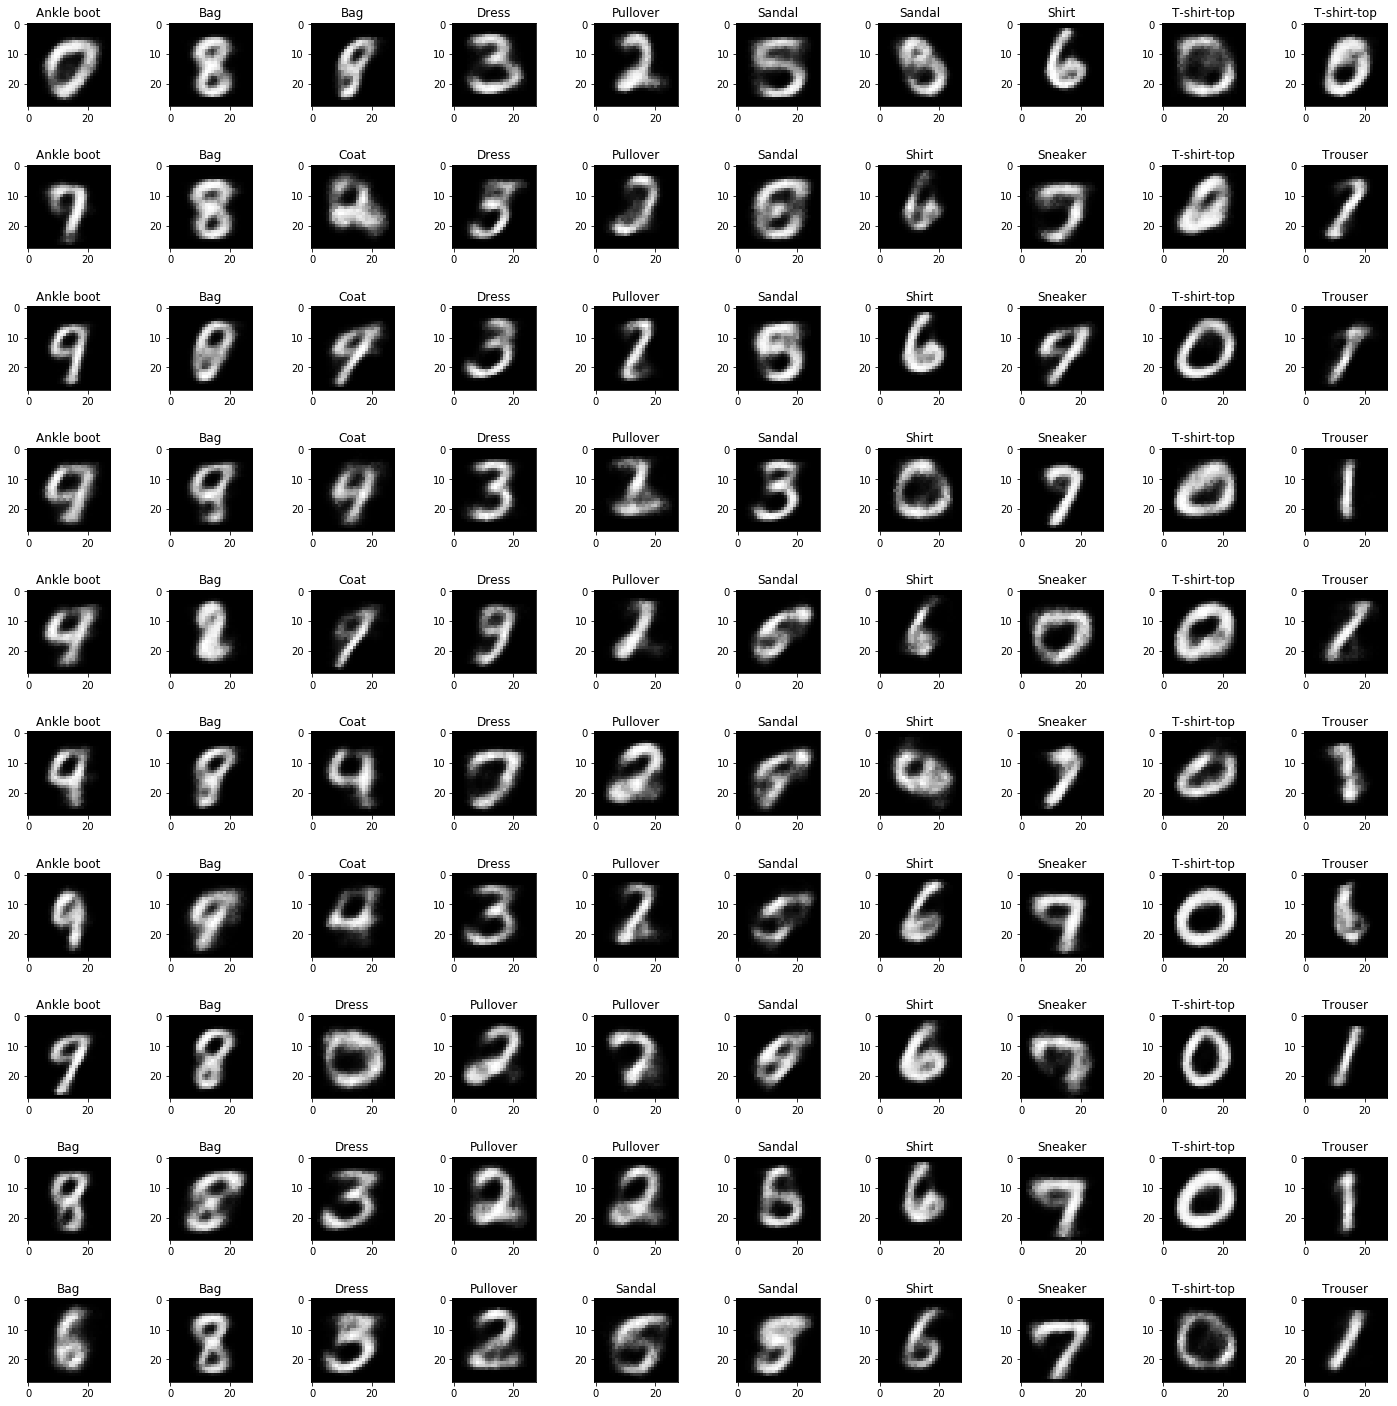

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # training
    print("Learning: ")
    for epoch in range(epochs):
        total_loss = 0.0
        loss_lik   = 0.0
        loss_div   = 0.0
        for i in range(0, total_batch):
            (batch, _) = data.train.next_batch(batch_size)
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (train_op, loss, neg_marginal_likelihood, KL_divergence),
                feed_dict={ input_layer: batch }
            )
            total_loss += tot_loss
            loss_lik   += loss_likelihood
            loss_div   += loss_divergence
        print("   - epoch: ", epoch, total_loss, loss_lik, loss_div)

    
    #  creating reconstruction from test images
    print("Reconstruction: ")
    (images, labels) = data.test.next_batch(100)
    a = 0
    b = 0
    latent_img = []
    for i in range(0, 100):
        print(" - reconstructing: " + labels_dict[labels[i]], a, b, i)
        y_out, u    = sess.run((y, z), feed_dict={input_layer: images[i].reshape(1, 784)})
        y_img       = y_out.reshape(28, 28)
        latent_img += [(y_img, labels_dict[labels[i]])]
    latent_img = sorted(latent_img, key = lambda x : x[1])

    # plotting
    print("Plotting")
    f, axarr = plt.subplots(10, 10)
    for i in range(0, 100):        
        if a == 10:
            a = 0
            b += 1

        axarr[a, b].set_title(latent_img[i][1])
        axarr[a, b].imshow(latent_img[i][0], cmap=plt.get_cmap('gray'))  
        a += 1
        
    f.subplots_adjust(hspace = 0.7)
    f.set_size_inches(25.0, 25.0, forward=True)
    plt.savefig("prediction.png")        

print("Done")